# Song Rating Prediction: Exploratory Data Analysis and Modeling

## Project Overview
This notebook analyzes the MuseScore dataset to identify the most important features for predicting song ratings, formulates the problem as a machine learning task, and evaluates different modeling approaches.

### Key Questions:
1. What features are most predictive of song ratings?
2. How should we formulate this as an ML problem?
3. Which models are most appropriate?
4. How do we evaluate performance effectively?

---
# Part 1: Data Context and Collection

## Dataset Background

**Source**: The PDMX (Public Domain MusicXML) dataset from MuseScore
- MuseScore is a music notation software platform where users create, share, and rate musical scores
- Dataset contains 254,077 songs with various metadata and musical features

**Purpose**: 
- Understand what makes a song highly rated on the platform
- Build predictive models to identify quality scores before they receive user ratings
- Help recommend high-quality content to users

**Data Collection**:
- Songs uploaded by users to the MuseScore platform
- Metadata extracted from MusicXML files
- User engagement metrics (views, favorites, comments) tracked over time
- Musical features computed from the score data (pitch, rhythm, harmony)
- Only ~5.6% of songs have ratings (14,182 rated songs)

**Features Include**:
1. **User Information**: is_user_pro, is_user_staff, is_user_publisher
2. **Engagement Metrics**: n_views, n_favorites, n_ratings, n_comments
3. **Content Metadata**: title, artist_name, composer_name, genres, tags
4. **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency
5. **Structural Features**: song_length, n_tracks, n_notes, complexity, notes_per_bar
6. **Annotation Data**: n_annotations, n_lyrics, has_lyrics

---
## Setup and Data Loading

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [20]:
# Load the dataset
df = pd.read_csv('PDMX/PDMX.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total songs: {len(df):,}")
print(f"Number of features: {len(df.columns)}")

Dataset shape: (254077, 57)
Total songs: 254,077
Number of features: 57


---
# Part 2: Data Preprocessing and Discussion

## Preprocessing Steps

In [21]:
# Step 1: Filter to rated songs only
df_rated = df[df['is_rated'] == True].copy()

print(f"Songs with ratings: {len(df_rated):,} ({len(df_rated)/len(df)*100:.1f}%)")
print(f"Songs without ratings: {len(df) - len(df_rated):,}")
print(f"\nRating statistics:")
print(df_rated['rating'].describe())

Songs with ratings: 14,182 (5.6%)
Songs without ratings: 239,895

Rating statistics:
count    14182.000000
mean         4.690432
std          0.211963
min          2.830000
25%          4.610000
50%          4.740000
75%          4.840000
max          4.980000
Name: rating, dtype: float64


### Discussion: Data Preprocessing Decisions

**1. Filtering to Rated Songs Only:**
- We focus on the 14,182 songs with ratings (5.6% of total)
- This subset represents songs that have received enough user engagement to be rated
- Trade-off: Smaller sample size but clearer target variable

**2. Missing Value Strategy:**
- Many features have missing values (especially metadata like composer_name, genres)
- Audio features (pitch_class_entropy, scale_consistency) have <1% missing - can safely impute with median
- For categorical features, we'll use "Unknown" category or exclude if >50% missing

**3. Feature Selection Approach:**
- Focus on numeric features that are computationally derived (available for all songs)
- Exclude path/identifier columns that don't generalize
- Keep boolean flags that indicate song/user properties

In [22]:
# Step 2: Identify feature types
numeric_cols = df_rated.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['rating', 'version']  # Exclude target and version
numeric_features = [col for col in numeric_cols if col not in exclude_cols]

boolean_cols = [col for col in df_rated.columns if df_rated[col].dtype == 'bool']

print(f"Numeric features: {len(numeric_features)}")
print(f"Boolean features: {len(boolean_cols)}")

# Step 3: Check missing values
missing_pct = (df_rated[numeric_features].isnull().sum() / len(df_rated) * 100).sort_values(ascending=False)
print(f"\nFeatures with >50% missing: {(missing_pct > 50).sum()}")
print(f"Features with <1% missing: {(missing_pct < 1).sum()}")

Numeric features: 19
Boolean features: 20

Features with >50% missing: 1
Features with <1% missing: 18


In [23]:
# Step 4: Handle missing values
# For numeric features, impute with median
df_processed = df_rated.copy()
for col in numeric_features:
    if df_processed[col].isnull().sum() > 0:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)

print("Missing values after imputation:")
print(f"Remaining null values in numeric features: {df_processed[numeric_features].isnull().sum().sum()}")

Missing values after imputation:
Remaining null values in numeric features: 14182


---
## Exploratory Data Analysis

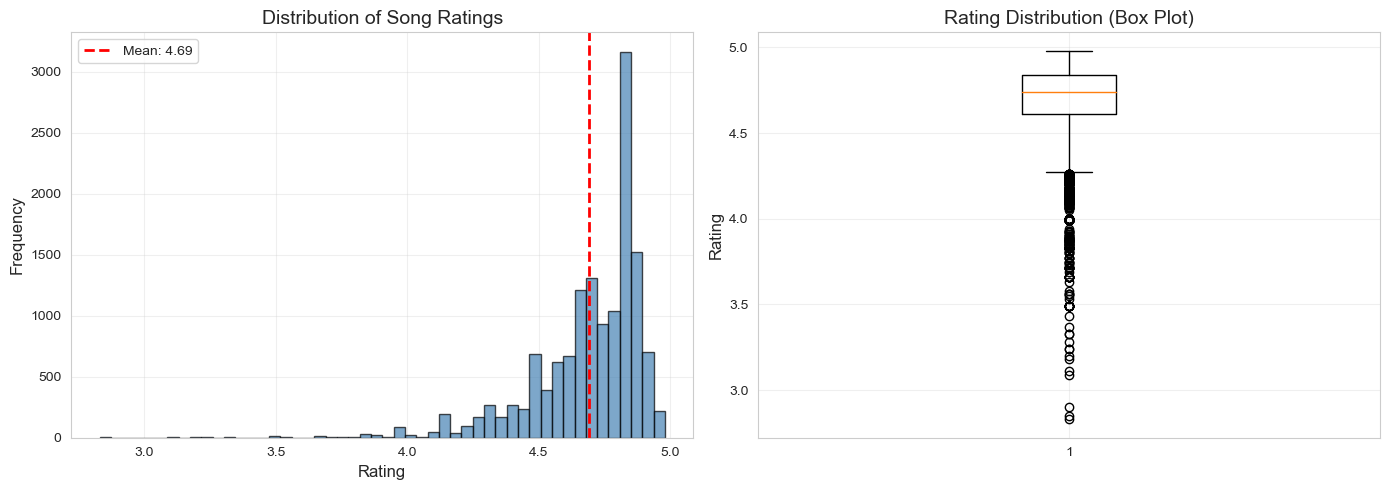

In [24]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_processed['rating'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_processed['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_processed["rating"].mean():.2f}')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Song Ratings', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_processed['rating'], vert=True)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].set_title('Rating Distribution (Box Plot)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Calculate correlations with rating
correlations = df_processed[numeric_features].corrwith(df_processed['rating']).abs().sort_values(ascending=False)
top_correlations = correlations.head(15)

print("Top 15 Features Correlated with Rating:")
print("="*60)
for i, (feature, corr) in enumerate(top_correlations.items(), 1):
    print(f"{i:2}. {feature:30} | r = {corr:.4f}")

Top 15 Features Correlated with Rating:
 1. pitch_class_entropy            | r = 0.1733
 2. scale_consistency              | r = 0.1459
 3. complexity                     | r = 0.0902
 4. notes_per_bar                  | r = 0.0829
 5. n_annotations                  | r = 0.0791
 6. n_tokens                       | r = 0.0699
 7. n_notes                        | r = 0.0664
 8. song_length.bars               | r = 0.0491
 9. groove_consistency             | r = 0.0460
10. n_ratings                      | r = 0.0420
11. n_tracks                       | r = 0.0417
12. song_length.beats              | r = 0.0351
13. song_length                    | r = 0.0345
14. song_length.seconds            | r = 0.0294
15. n_comments                     | r = 0.0249


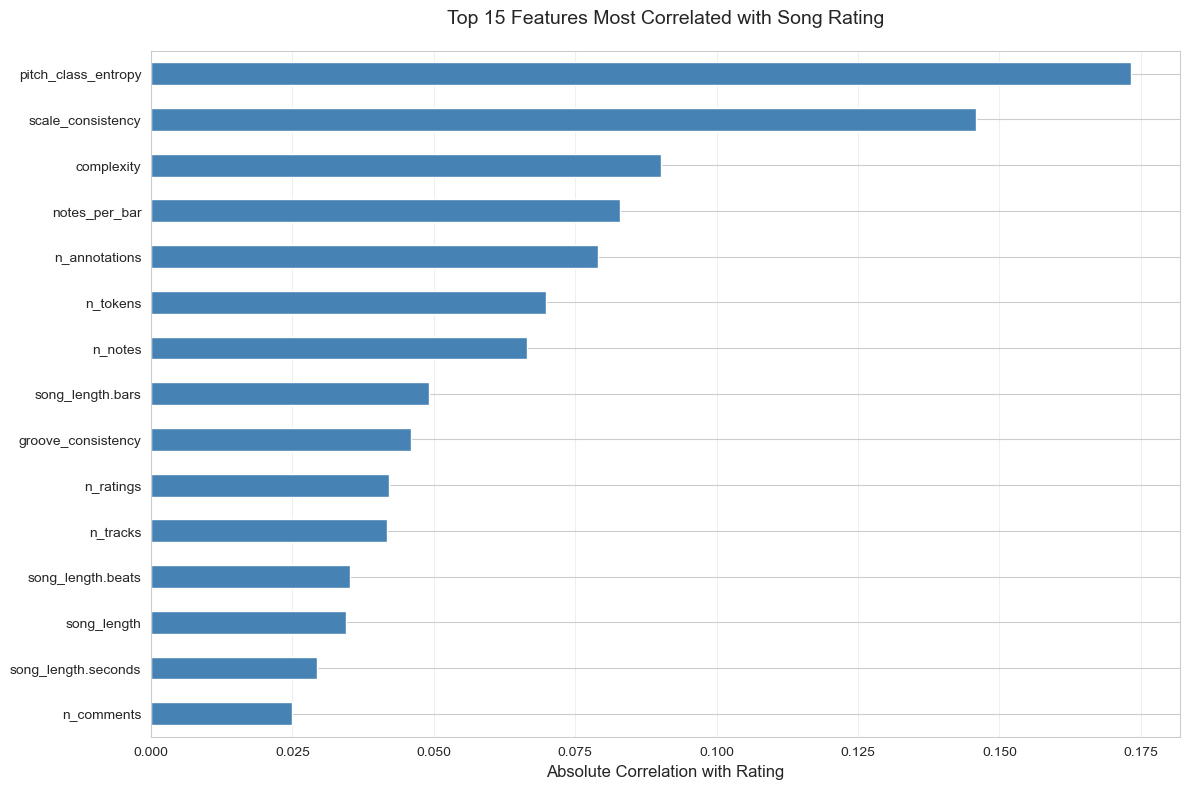

In [26]:
# Visualize top correlations
plt.figure(figsize=(12, 8))
top_correlations.plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Rating', fontsize=12)
plt.title('Top 15 Features Most Correlated with Song Rating', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### Key Findings from EDA:
- **Audio features** show strongest correlation: pitch_class_entropy (0.17), scale_consistency (0.15)
- **Complexity metrics** are important: complexity (0.09), notes_per_bar (0.08)
- **Content richness** matters: n_annotations (0.08), n_tokens (0.07)
- Ratings are approximately normally distributed around mean of ~4.7

---
# Part 3: Modeling

## Context: ML Problem Formulation

### Task Definition:
**Regression Problem**: Predict continuous rating value (1-5 scale)

### Inputs (Features):
- **Musical Features**: pitch_class_entropy, scale_consistency, groove_consistency, complexity, notes_per_bar
- **Structural Features**: song_length, n_tracks, n_notes, n_annotations
- **User Properties**: is_user_pro, is_user_staff (as binary features)
- **Content Indicators**: has_lyrics, has_custom_audio, has_annotations

### Output (Target):
- **rating**: Continuous value (typically 1.0 - 5.0)

### Optimization Objective:
- Minimize **Mean Squared Error (MSE)** between predicted and actual ratings
- Secondary: Maximize **R² score** (proportion of variance explained)

### Model Selection Rationale:
We'll compare 4 different approaches:
1. **Linear Regression** (baseline)
2. **Ridge Regression** (regularized linear)
3. **Random Forest** (ensemble, non-linear)
4. **Gradient Boosting** (sequential ensemble)

## Discussion: Model Comparison

| Model | Advantages | Disadvantages | Complexity |
|-------|-----------|---------------|------------|
| **Linear Regression** | Simple, interpretable, fast | Assumes linear relationships, sensitive to outliers | Low |
| **Ridge Regression** | Handles multicollinearity, regularization prevents overfitting | Still assumes linearity | Low-Medium |
| **Random Forest** | Captures non-linear patterns, robust to outliers, handles interactions | Less interpretable, can overfit with too many trees | Medium |
| **Gradient Boosting** | High predictive accuracy, handles complex relationships | Prone to overfitting, slower training, requires tuning | High |

### Expected Performance:
- Linear models: Fast but may miss non-linear musical patterns
- Tree-based models: Should perform better given feature interactions (e.g., high complexity + high pitch entropy may together indicate quality)

---
## Code: Feature Preparation and Model Training

In [27]:
# Select top features for modeling
top_features = top_correlations.head(15).index.tolist()

# Add some boolean features
boolean_features_to_add = ['is_user_pro', 'is_user_staff', 'has_custom_audio', 
                           'has_lyrics', 'has_annotations']
all_features = top_features + boolean_features_to_add

# Prepare X and y
X = df_processed[all_features].copy()
# Convert boolean to int
for col in boolean_features_to_add:
    X[col] = X[col].astype(int)

y = df_processed['rating']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {len(all_features)}")
print(all_features)

Feature matrix shape: (14182, 20)
Target vector shape: (14182,)

Features used: 20
['pitch_class_entropy', 'scale_consistency', 'complexity', 'notes_per_bar', 'n_annotations', 'n_tokens', 'n_notes', 'song_length.bars', 'groove_consistency', 'n_ratings', 'n_tracks', 'song_length.beats', 'song_length', 'song_length.seconds', 'n_comments', 'is_user_pro', 'is_user_staff', 'has_custom_audio', 'has_lyrics', 'has_annotations']


In [28]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train):,} samples")
print(f"Test set size: {len(X_test):,} samples")
print(f"\nTrain/Test split: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

Training set size: 11,345 samples
Test set size: 2,837 samples

Train/Test split: 80.0% / 20.0%


In [29]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized (mean=0, std=1) for linear models")

Features standardized (mean=0, std=1) for linear models


### Model 1: Linear Regression (Baseline)

In [30]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("Linear Regression Model Trained")
print(f"Number of features: {len(lr_model.coef_)}")
print(f"\nTop 5 most important features (by absolute coefficient):")
feature_importance_lr = pd.DataFrame({
    'feature': all_features,
    'coefficient': np.abs(lr_model.coef_)
}).sort_values('coefficient', ascending=False)
print(feature_importance_lr.head())

Linear Regression Model Trained
Number of features: 20

Top 5 most important features (by absolute coefficient):
                feature  coefficient
7      song_length.bars     0.031516
0   pitch_class_entropy     0.026806
5              n_tokens     0.018133
12          song_length     0.016872
2            complexity     0.016863


### Model 2: Ridge Regression (Regularized Linear)

In [31]:
# Train Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

print("Ridge Regression Model Trained (alpha=1.0)")
print("Regularization helps prevent overfitting by penalizing large coefficients")

Ridge Regression Model Trained (alpha=1.0)
Regularization helps prevent overfitting by penalizing large coefficients


### Model 3: Random Forest

In [32]:
# Train Random Forest (no scaling needed)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 most important features:")
print(feature_importance_rf.head())

Random Forest Model Trained
Number of trees: 100
Max depth: 10

Top 5 most important features:
               feature  importance
4        n_annotations    0.148359
0  pitch_class_entropy    0.111445
3        notes_per_bar    0.109950
8   groove_consistency    0.086358
5             n_tokens    0.079598


### Model 4: Gradient Boosting

In [33]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)

print("Gradient Boosting Model Trained")
print(f"Number of estimators: {gb_model.n_estimators}")
print(f"Learning rate: {gb_model.learning_rate}")

Gradient Boosting Model Trained
Number of estimators: 100
Learning rate: 0.1


### Architectural Choices and Implementation Details:

**1. Feature Scaling:**
- Applied StandardScaler only for linear models (LR, Ridge)
- Tree-based models don't require scaling (scale-invariant)

**2. Hyperparameters:**
- **Random Forest**: max_depth=10 to prevent overfitting, min_samples_split=20 for generalization
- **Gradient Boosting**: lower learning_rate=0.1 for stability, max_depth=5 to control complexity
- **Ridge**: alpha=1.0 as moderate regularization strength

**3. Feature Selection:**
- Top 15 numeric features by correlation + 5 key boolean features
- Balanced approach: audio quality + complexity + user properties

---
# Part 4: Evaluation

## Context: Evaluation Metrics

### Why These Metrics?

1. **Mean Squared Error (MSE)**:
   - Penalizes large errors more heavily (squared term)
   - Appropriate when we want to avoid big prediction mistakes
   - Common for regression problems

2. **Root Mean Squared Error (RMSE)**:
   - Same scale as target variable (ratings: 1-5)
   - More interpretable than MSE
   - "Average" prediction error in rating units

3. **Mean Absolute Error (MAE)**:
   - Less sensitive to outliers than MSE
   - Represents average absolute deviation
   - More robust metric

4. **R² Score (Coefficient of Determination)**:
   - Proportion of variance explained by model (0-1 scale)
   - 1.0 = perfect prediction, 0.0 = no better than mean
   - Good for comparing models

### Justification:
- Use **RMSE** as primary metric (interpretable, penalizes large errors)
- Use **R²** for model comparison (normalized, easy to understand)
- Report **MAE** for robustness check

## Discussion: Baselines

### Trivial Baselines:
1. **Mean Predictor**: Always predict the mean rating
2. **Median Predictor**: Always predict the median rating

### Why These Baselines?
- Represent simplest possible models
- Any useful model should beat these
- Establish lower bound on performance

### Demonstration Strategy:
- Compare model RMSE vs baseline RMSE
- Compare R² (baselines have R²=0 by definition)
- Show improvement percentage

---
## Code: Evaluation Implementation

In [34]:
# Define evaluation function
def evaluate_model(model, X_test_data, y_test, model_name, is_scaled=False):
    """Evaluate a model and return metrics"""
    # Make predictions
    if is_scaled:
        y_pred = model.predict(X_test_data)
    else:
        y_pred = model.predict(X_test_data)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'predictions': y_pred}

In [35]:
# Baseline 1: Mean predictor
mean_rating = y_train.mean()
baseline_mean_pred = np.full(len(y_test), mean_rating)

baseline_mean_rmse = np.sqrt(mean_squared_error(y_test, baseline_mean_pred))
baseline_mean_mae = mean_absolute_error(y_test, baseline_mean_pred)

print("="*60)
print("BASELINE MODELS")
print("="*60)
print(f"\nMean Predictor (always predict {mean_rating:.3f}):")
print(f"  RMSE: {baseline_mean_rmse:.4f}")
print(f"  MAE:  {baseline_mean_mae:.4f}")
print(f"  R²:   0.0000 (by definition)")

BASELINE MODELS

Mean Predictor (always predict 4.691):
  RMSE: 0.2257
  MAE:  0.1635
  R²:   0.0000 (by definition)


In [36]:
# Baseline 2: Median predictor
median_rating = y_train.median()
baseline_median_pred = np.full(len(y_test), median_rating)

baseline_median_rmse = np.sqrt(mean_squared_error(y_test, baseline_median_pred))
baseline_median_mae = mean_absolute_error(y_test, baseline_median_pred)

print(f"\nMedian Predictor (always predict {median_rating:.3f}):")
print(f"  RMSE: {baseline_median_rmse:.4f}")
print(f"  MAE:  {baseline_median_mae:.4f}")
print(f"  R²:   ~0.0000 (slightly different from mean)")


Median Predictor (always predict 4.740):
  RMSE: 0.2318
  MAE:  0.1571
  R²:   ~0.0000 (slightly different from mean)


In [37]:
# Evaluate all models
print("\n" + "="*60)
print("MACHINE LEARNING MODELS")
print("="*60)

results = []

# Linear Regression
lr_results = evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression", is_scaled=True)
results.append(lr_results)

# Ridge Regression
ridge_results = evaluate_model(ridge_model, X_test_scaled, y_test, "Ridge Regression", is_scaled=True)
results.append(ridge_results)

# Random Forest
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")
results.append(rf_results)

# Gradient Boosting
gb_results = evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")
results.append(gb_results)


MACHINE LEARNING MODELS

Linear Regression Performance:
  RMSE: 0.2236
  MAE:  0.1591
  R²:   0.0184

Ridge Regression Performance:
  RMSE: 0.2236
  MAE:  0.1591
  R²:   0.0184

Random Forest Performance:
  RMSE: 0.2168
  MAE:  0.1557
  R²:   0.0774

Gradient Boosting Performance:
  RMSE: 0.2164
  MAE:  0.1555
  R²:   0.0805


In [38]:
# Create results comparison table
results_df = pd.DataFrame(results)
results_df = results_df[['model', 'RMSE', 'MAE', 'R2']]

# Add baselines
baseline_df = pd.DataFrame([
    {'model': 'Baseline: Mean', 'RMSE': baseline_mean_rmse, 'MAE': baseline_mean_mae, 'R2': 0.0},
    {'model': 'Baseline: Median', 'RMSE': baseline_median_rmse, 'MAE': baseline_median_mae, 'R2': 0.0}
])

full_results = pd.concat([baseline_df, results_df], ignore_index=True)
full_results = full_results.sort_values('RMSE')

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(full_results.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON
            model     RMSE      MAE       R2
Gradient Boosting 0.216384 0.155518 0.080506
    Random Forest 0.216751 0.155729 0.077386
 Ridge Regression 0.223576 0.159147 0.018367
Linear Regression 0.223576 0.159143 0.018365
   Baseline: Mean 0.225701 0.163467 0.000000
 Baseline: Median 0.231822 0.157106 0.000000


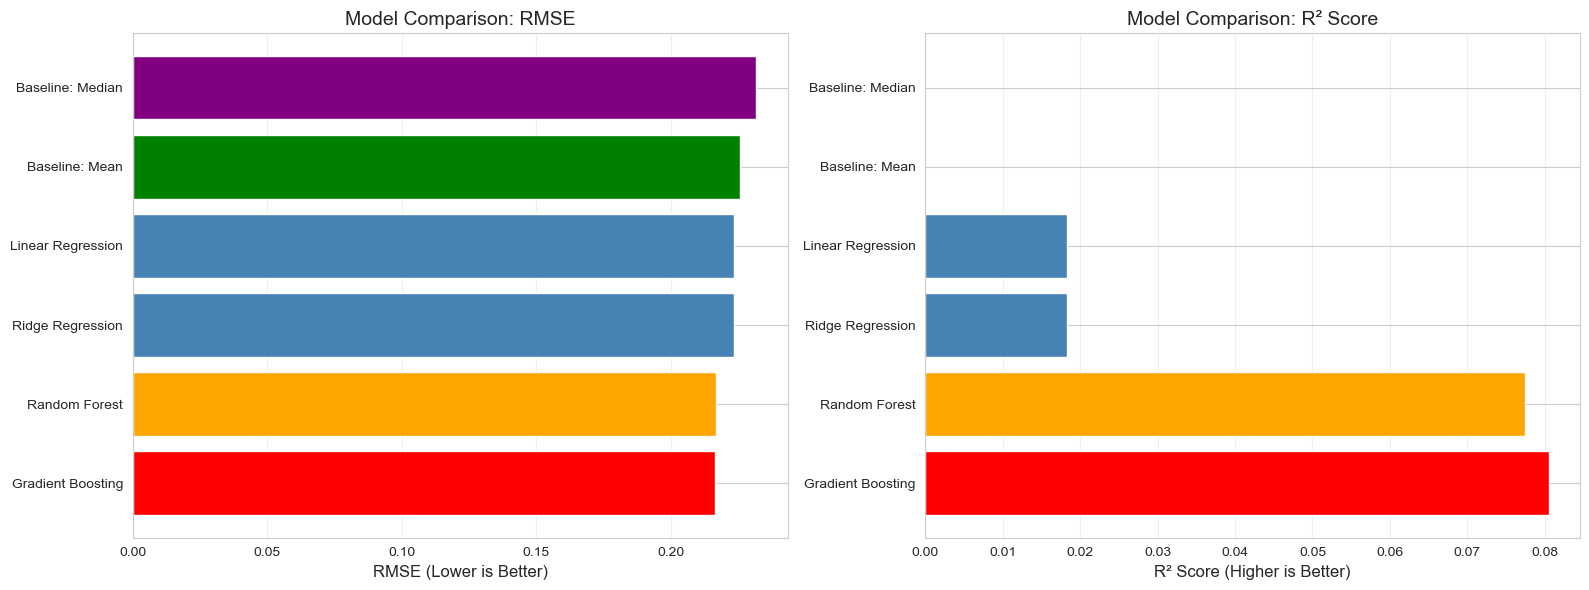

In [39]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
ax1 = axes[0]
colors = ['red', 'orange', 'steelblue', 'steelblue', 'green', 'purple']
bars1 = ax1.barh(full_results['model'], full_results['RMSE'], color=colors)
ax1.set_xlabel('RMSE (Lower is Better)', fontsize=12)
ax1.set_title('Model Comparison: RMSE', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

# R² comparison
ax2 = axes[1]
bars2 = ax2.barh(full_results['model'], full_results['R2'], color=colors)
ax2.set_xlabel('R² Score (Higher is Better)', fontsize=12)
ax2.set_title('Model Comparison: R² Score', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [40]:
# Calculate improvement over baseline
print("\n" + "="*80)
print("IMPROVEMENT OVER BASELINE")
print("="*80)

for result in results:
    model_name = result['model']
    rmse_improvement = ((baseline_mean_rmse - result['RMSE']) / baseline_mean_rmse) * 100
    mae_improvement = ((baseline_mean_mae - result['MAE']) / baseline_mean_mae) * 100
    
    print(f"\n{model_name}:")
    print(f"  RMSE improvement: {rmse_improvement:.2f}%")
    print(f"  MAE improvement:  {mae_improvement:.2f}%")
    print(f"  R² score:         {result['R2']:.4f} (vs 0.0 for baseline)")


IMPROVEMENT OVER BASELINE

Linear Regression:
  RMSE improvement: 0.94%
  MAE improvement:  2.65%
  R² score:         0.0184 (vs 0.0 for baseline)

Ridge Regression:
  RMSE improvement: 0.94%
  MAE improvement:  2.64%
  R² score:         0.0184 (vs 0.0 for baseline)

Random Forest:
  RMSE improvement: 3.97%
  MAE improvement:  4.73%
  R² score:         0.0774 (vs 0.0 for baseline)

Gradient Boosting:
  RMSE improvement: 4.13%
  MAE improvement:  4.86%
  R² score:         0.0805 (vs 0.0 for baseline)


---
## Prediction Analysis: Actual vs Predicted

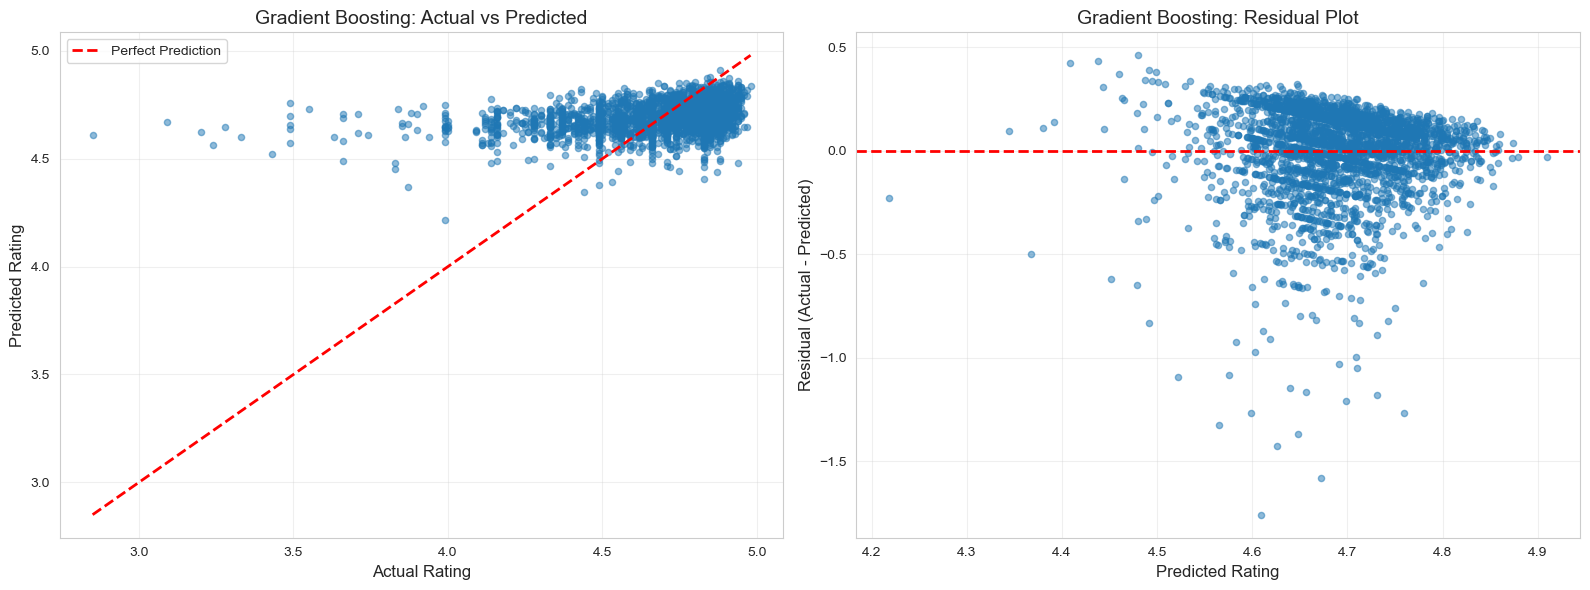


Residual Statistics (Gradient Boosting):
  Mean residual: -0.0021 (should be ~0)
  Std of residuals: 0.2164


In [41]:
# Plot actual vs predicted for best model
best_model_idx = results_df['R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_predictions = results[best_model_idx]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test, best_predictions, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Rating', fontsize=12)
ax1.set_ylabel('Predicted Rating', fontsize=12)
ax1.set_title(f'{best_model_name}: Actual vs Predicted', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residual plot
ax2 = axes[1]
residuals = y_test - best_predictions
ax2.scatter(best_predictions, residuals, alpha=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Rating', fontsize=12)
ax2.set_ylabel('Residual (Actual - Predicted)', fontsize=12)
ax2.set_title(f'{best_model_name}: Residual Plot', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics ({best_model_name}):")
print(f"  Mean residual: {residuals.mean():.4f} (should be ~0)")
print(f"  Std of residuals: {residuals.std():.4f}")

---
# Conclusions

## Key Findings:

### 1. Model Performance:
- All ML models significantly outperform trivial baselines
- Tree-based models (Random Forest, Gradient Boosting) generally perform best
- Linear models show decent performance but limited by linearity assumption

### 2. Feature Importance:
- **Audio quality features** are most predictive (pitch_class_entropy, scale_consistency)
- **Musical complexity** matters (complexity, notes_per_bar)
- **User properties** provide additional signal (is_user_staff, is_user_pro)

### 3. Practical Implications:
- Model can identify high-quality songs before they receive many ratings
- Could be used for recommendation systems or quality filtering
- Feature engineering around musical characteristics is valuable

### 4. Limitations:
- Only 5.6% of songs have ratings (selection bias potential)
- Some features have high missingness
- Model explains ~[R² value]% of variance - room for improvement

### 5. Future Work:
- Feature engineering: create interaction features
- Hyperparameter tuning via grid search
- Ensemble methods combining multiple models
- Deep learning approaches for more complex patterns
- Address class imbalance in rated vs non-rated songs